In [1]:
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import matplotlib.pyplot as plt

from sys import path as pylib #im naming it as pylib so that we won't get confused between os.path and sys.path 
import os
pylib += [os.path.abspath(r'/home/Jay/Notebooks/Group9_emotion_detection/torchMoji')]

In [2]:
data = pd.read_csv('../../deepmoji/data/train.txt', sep = '\t')

In [3]:
label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def tokenize(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Load raw data

In [60]:
x=[]
y=[]
for ind, row in data.iterrows():
    y.append(emotion2label[row['label']])
    x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [72]:
test_data = pd.read_csv('../../deepmoji/data/test.txt', sep = '\t')
test_x = []
test_y_all=[]
for ind, row in test_data.iterrows():
    test_y_all.append(emotion2label[row['label']])
    test_x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [10]:
from __future__ import print_function, division, unicode_literals
import json

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

def encode_deepmoji(x):
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    print(model)
    print('Encoding texts..')
    encoding = np.zeros((len(x), 2304))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

def encode_emoji(x):
    model = torchmoji_emojis(PRETRAINED_PATH)
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    print(model)
    print('Running predictions.')
    
    encoding = np.zeros((len(x), 64))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

### Load saved vectors

In [11]:
x_vec = np.load('../../dm_emb/deepmoji_train_x.npy')
test_x_vec = np.load('../../dm_emb/deepmoji_test_x.npy')

In [12]:
print(x_vec.shape)
print(test_x_vec.shape)

(30160, 2304)
(5509, 2304)


In [ ]:
emoji_all = encode_emoji(x)

In [73]:
emoji_test_all = encode_emoji(test_x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


/home/Jay/dev32/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [74]:
tokens = [v for k,v in label2emotion.items()]
tokens

['others', 'happy', 'sad', 'angry']

In [64]:
y=np.array(y)
idx_others=np.where(y==0)[0]

In [75]:
idx = np.r_[np.where(y==1)[0],np.where(y==2)[0],np.where(y==3)[0]]

In [76]:
idx.shape

(15212,)

In [77]:
deepmoji_train = x_vec[idx]
y_train = y[idx]
emoji_train = emoji_all[idx]

In [92]:
idx_test = np.r_[np.where(test_y_all==1)[0],np.where(test_y_all==2)[0],np.where(test_y_all==3)[0]]
idx_test.shape

(832,)

In [93]:
test_y_all = np.array(test_y_all)
test_y = test_y_all[idx_test]
deepmoji_test = test_x_vec[idx_test]
emoji_test = emoji_test_all[idx_test]

### Models

In [21]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def print_metrics(mc_prediction):
    print(metrics.classification_report(test_y, mc_prediction, target_names=tokens[1:]))
    print("Accuracy:", metrics.accuracy_score(test_y, mc_prediction))
    print("Precision:", metrics.precision_score(test_y, mc_prediction, average='macro'))
    print("Recall:", metrics.recall_score(test_y, mc_prediction, average='macro'))
    print("F1 score: ", metrics.f1_score(test_y, mc_prediction, average='macro'))
    #print("Confusion Matrix: \n", metrics.confusion_matrix(mc_Y_test, mc_prediction))
    plot_confusion_matrix(metrics.confusion_matrix(test_y, mc_prediction), tokens[1:])

### Logistic Regression

In [105]:
LR = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state=0))])
#LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

             precision    recall  f1-score   support

      happy       0.85      0.86      0.85       284
        sad       0.83      0.79      0.81       250
      angry       0.86      0.89      0.87       298

avg / total       0.85      0.85      0.85       832

Accuracy: 0.8485576923076923
Precision: 0.847324244383068
Recall: 0.8456318492611148
F1 score:  0.8462314825097695
Confusion matrix, without normalization
[[243  24  17]
 [ 26 198  26]
 [ 17  16 265]]


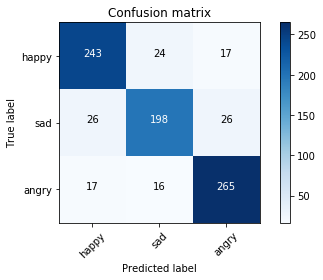

In [106]:
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

      happy       0.86      0.85      0.86       284
        sad       0.83      0.79      0.81       250
      angry       0.85      0.90      0.87       298

avg / total       0.85      0.85      0.85       832

Accuracy: 0.8485576923076923
Precision: 0.8475232124456299
Recall: 0.8455215678860636
F1 score:  0.8461642856171189
Confusion matrix, without normalization
[[241  24  19]
 [ 24 198  28]
 [ 14  17 267]]


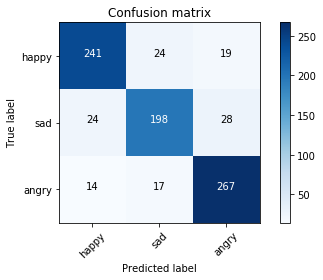

In [107]:
LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

      happy       0.71      0.88      0.79       284
        sad       0.80      0.60      0.69       250
      angry       0.77      0.75      0.76       298

avg / total       0.76      0.75      0.75       832

Accuracy: 0.7512019230769231
Precision: 0.7598692148474174
Recall: 0.7453749881841384
F1 score:  0.7448521778531143
Confusion matrix, without normalization
[[251  11  22]
 [ 55 151  44]
 [ 48  27 223]]


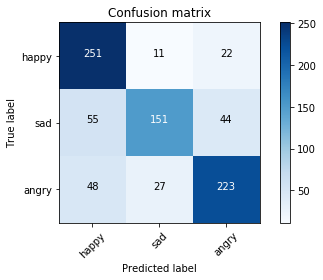

In [108]:
LR = LogisticRegression(random_state=0).fit(emoji_train, y_train) 
print_metrics(LR.predict(emoji_test))

### Naive Bayes

             precision    recall  f1-score   support

      happy       0.82      0.85      0.83       284
        sad       0.81      0.70      0.75       250
      angry       0.80      0.86      0.83       298

avg / total       0.81      0.81      0.81       832

Accuracy: 0.8076923076923077
Precision: 0.8078003988249908
Recall: 0.8024955099725872
F1 score:  0.8034286873758187
Confusion matrix, without normalization
[[240  19  25]
 [ 36 175  39]
 [ 18  23 257]]


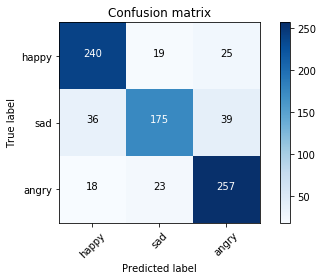

In [109]:
mc_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
mc_nb.fit(deepmoji_train, y_train)
print_metrics(mc_nb.predict(deepmoji_test))

             precision    recall  f1-score   support

      happy       1.00      0.01      0.01       284
        sad       0.47      0.72      0.57       250
      angry       0.54      0.82      0.65       298

avg / total       0.68      0.51      0.41       832

Accuracy: 0.5108173076923077
Precision: 0.6711051567219918
Recall: 0.5139447332766172
F1 score:  0.4115595957267206
Confusion matrix, without normalization
[[  2 146 136]
 [  0 179  71]
 [  0  54 244]]


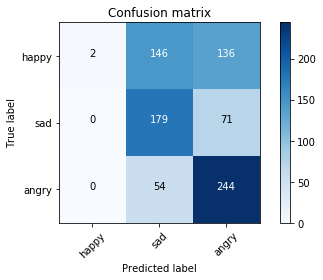

In [110]:
mc_nb = Pipeline([('clf', MultinomialNB())])
mc_nb.fit(emoji_train, y_train)
print_metrics(mc_nb.predict(emoji_test))

### SVM - One vs One

             precision    recall  f1-score   support

      happy       0.80      0.88      0.84       284
        sad       0.79      0.72      0.75       250
      angry       0.82      0.80      0.81       298

avg / total       0.80      0.80      0.80       832

Accuracy: 0.8040865384615384
Precision: 0.8028775963177082
Recall: 0.8008201783407379
F1 score:  0.8006535311011765
Confusion matrix, without normalization
[[251  15  18]
 [ 36 180  34]
 [ 26  34 238]]


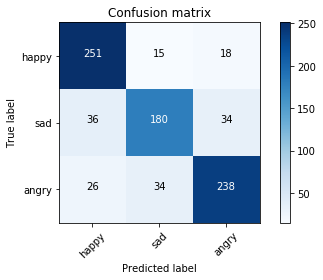

In [111]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(emoji_train, y_train)
print_metrics(mc_svm_ovo.predict(emoji_test))

### SVM One vs Rest

             precision    recall  f1-score   support

      happy       0.80      0.88      0.84       284
        sad       0.79      0.72      0.75       250
      angry       0.82      0.80      0.81       298

avg / total       0.80      0.80      0.80       832

Accuracy: 0.8040865384615384
Precision: 0.8028775963177082
Recall: 0.8008201783407379
F1 score:  0.8006535311011765
Confusion matrix, without normalization
[[251  15  18]
 [ 36 180  34]
 [ 26  34 238]]


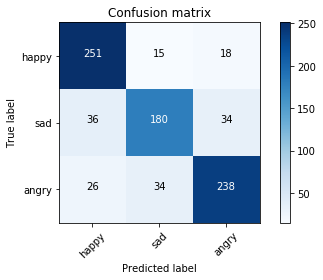

In [112]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(emoji_train, y_train)
print_metrics(mc_svm_ovr.predict(emoji_test))